In [2]:
!pip install kaggle
!kaggle datasets download -d paultimothymooney/breast-histopathology-images -p /content


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:31<00:00, 141MB/s]
100% 3.10G/3.10G [00:31<00:00, 106MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/breast-histopathology-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/breast-histopathology-images/')

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

In [5]:
breast_img = glob.glob('breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

breast-histopathology-images/IDC_regular_ps50_idx5/14306/0/14306_idx5_x1251_y801_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/14306/0/14306_idx5_x2101_y751_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/14306/0/14306_idx5_x2051_y1301_class0.png


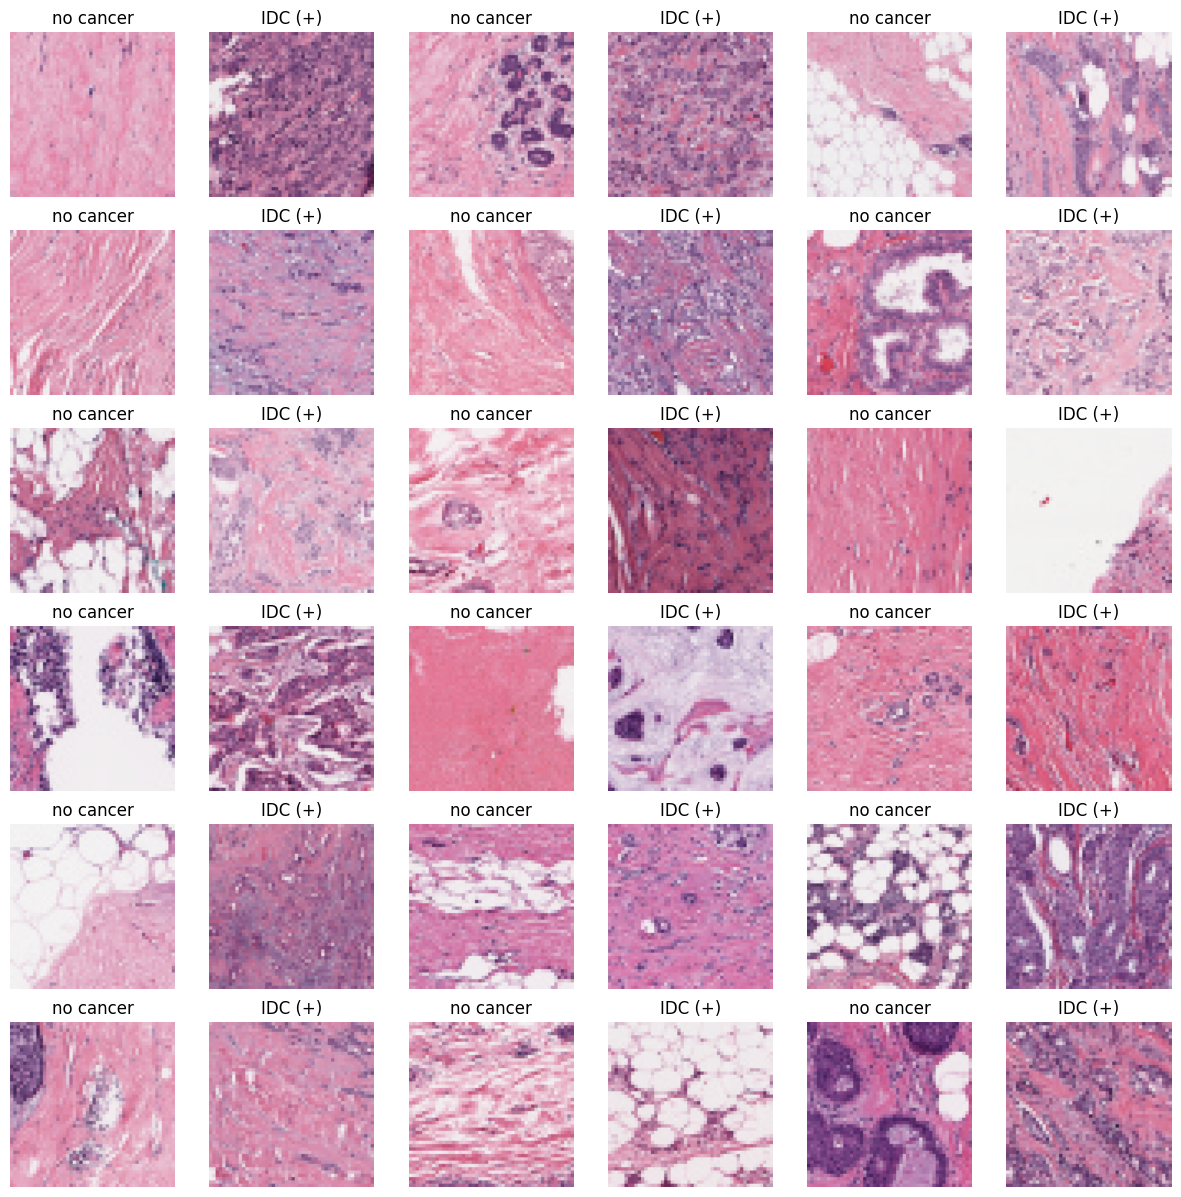

In [14]:
# Separate images based on label in the filename
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0':
        N_IDC.append(img)
    elif img[-5] == '1':
        P_IDC.append(img)

# Plot some sample images
plt.figure(figsize=(15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    img = image.load_img((N_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*s+1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img.astype('uint8'))
    s += 1

s = 1
for num in some_can:
    img = image.load_img((P_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*s)
    plt.axis('off')
    plt.title('IDC (+)')
    plt.imshow(img.astype('uint8'))
    s += 1

In [15]:
# Subset the negative samples to balance the dataset
NewN_IDC = N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [16]:
# Prepare image arrays
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr) + len(can_img_arr))

78786
78786
157572


In [17]:
# Combine and shuffle the image arrays
breast_img_arr = non_img_arr[:12389] + can_img_arr[:12389]
random.shuffle(breast_img_arr)

# Extract features and labels
X = [feature for feature, label in breast_img_arr]
y = [label for feature, label in breast_img_arr]

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(24778, 50, 50, 3)
(24778,)


In [18]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 24778
Number of IDC(-) Images: 12389
Number of IDC(+) Images: 12389
Image shape (Width, Height, Channels): (50, 50, 3)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


In [20]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [21]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [22]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                        

In [24]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 35)

Epoch 1/40
496/496 [==============================] - 314s 616ms/step - loss: 0.5192 - accuracy: 0.7768 - val_loss: 0.4804 - val_accuracy: 0.7981
Epoch 2/40
496/496 [==============================] - 321s 647ms/step - loss: 0.4197 - accuracy: 0.8232 - val_loss: 0.6032 - val_accuracy: 0.7275
Epoch 3/40
496/496 [==============================] - 316s 637ms/step - loss: 0.3854 - accuracy: 0.8387 - val_loss: 0.5345 - val_accuracy: 0.7846
Epoch 4/40
496/496 [==============================] - 320s 646ms/step - loss: 0.3636 - accuracy: 0.8477 - val_loss: 0.6052 - val_accuracy: 0.7255
Epoch 5/40
496/496 [==============================] - 310s 625ms/step - loss: 0.3581 - accuracy: 0.8470 - val_loss: 0.5645 - val_accuracy: 0.7363
Epoch 6/40
496/496 [==============================] - 316s 638ms/step - loss: 0.3362 - accuracy: 0.8564 - val_loss: 0.5414 - val_accuracy: 0.8087
Epoch 7/40
496/496 [==============================] - 318s 641ms/step - loss: 0.3336 - accuracy: 0.8576 - val_loss: 0.4661 -

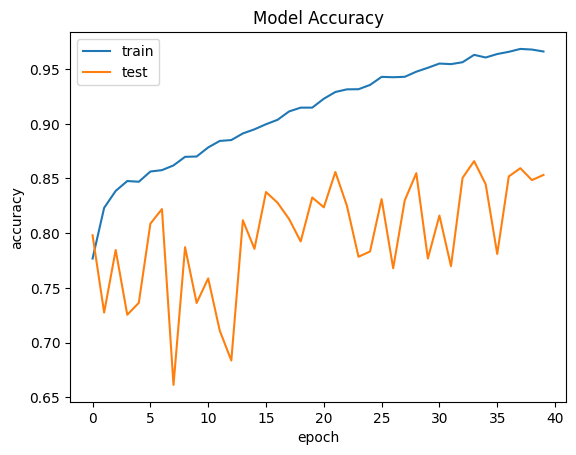

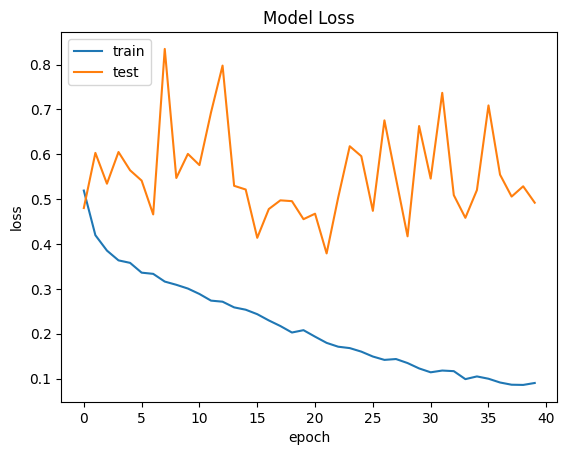

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

233/233 [==============================] - 32s 132ms/step


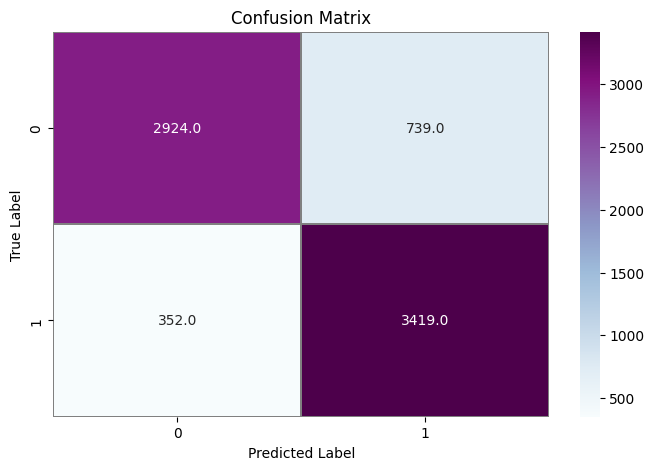

In [26]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_test,axis = 1)
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

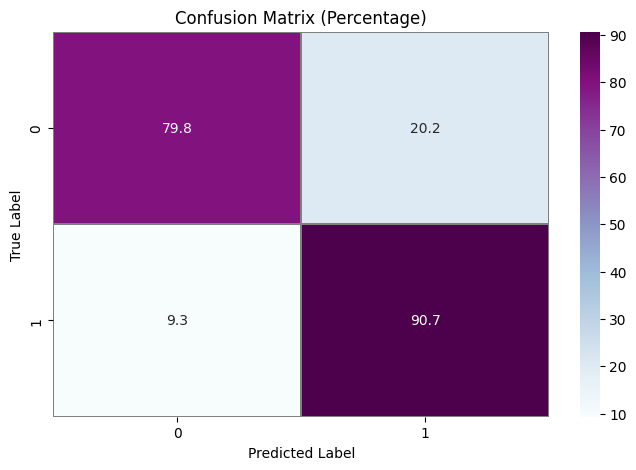

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [28]:
model.evaluate(X_test,Y_test)

233/233 [==============================] - 34s 143ms/step - loss: 0.4922 - accuracy: 0.8532


[0.49220362305641174, 0.8532418608665466]

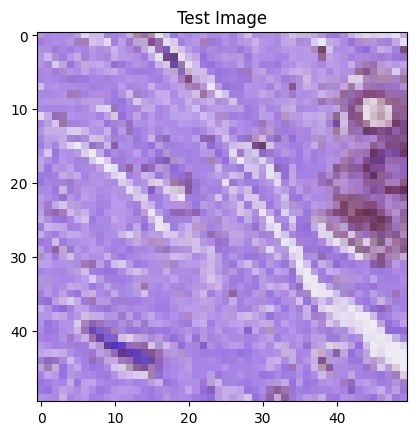

In [29]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 1000
img_plot(X_test, index)

In [30]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 [==============================] - 0s 105ms/step
Predicted Value using  cnn model 0
True Value 0


1/1 [==============================] - 0s 30ms/step


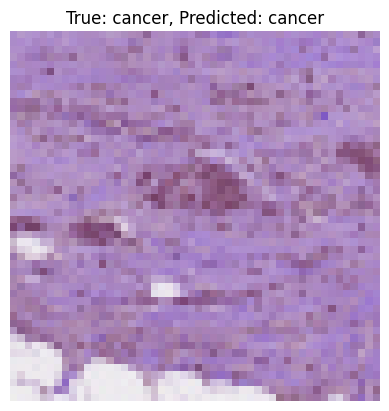

In [54]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Menggunakan gambar dari dataset untuk pengujian
index = random.randint(0, len(X_test) - 1)
input_img = X_test[index:index+1]
true_label = Y_test[index].argmax()
predicted_label = model.predict(input_img)[0].argmax()

# Plot gambar dan prediksi
plt.imshow(X_test[index].astype('uint8'))
plt.title(f'True: {"no cancer" if true_label == 0 else "cancer"}, Predicted: {"no cancer" if predicted_label == 0 else "cancer"}')
plt.axis('off')
plt.show()


In [55]:
model.save("Brest CNN 2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
